In [1]:
import cv2
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats

from p_body_randomness.extract_sample_areas import extract_sample_area
from p_body_randomness.smooth_image import smooth_protein_image
from p_body_randomness.centroids import extract_centroids

In [2]:
# Importing image files.
TEMPLATE_PATH = '../data/input_data/20180606-SLP_Multiplexing_p1_C03_x00{x}_y000_z000_t000_{image_type}_Label{label}.png'
NUM_IMAGES = 10
MIN_CENTROIDS = 5

image_types = {'pbodies': '13_Pbody_Segm', 'protein': '13_Succs', 'cellmask': 'segmentation', 'dapi': '2_DAPI'}

images = []
while len(images) < NUM_IMAGES:
    candidate = {'x': np.random.randint(0, 5), 'label': np.random.randint(0, 40)}
    if Path(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies'])).is_file():
        if len(extract_centroids(cv2.imread(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies']), 0))) >= MIN_CENTROIDS:
            images.append(candidate)

for candidate in images:
    print(candidate)

{'x': 1, 'label': 22}
{'x': 0, 'label': 37}
{'x': 1, 'label': 12}
{'x': 4, 'label': 21}
{'x': 1, 'label': 13}
{'x': 2, 'label': 27}
{'x': 2, 'label': 13}
{'x': 2, 'label': 9}
{'x': 4, 'label': 36}
{'x': 4, 'label': 24}


In [3]:
n = 1

cellMask = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = 'segmentation', label =images[n]['label']), 0)
pBodies  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Pbody_Segm', label = images[n]['label']), 0)
nucleus  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '2_DAPI', label = images[n]['label']), 0)
proteins = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Succs', label = images[n]['label']), 0)

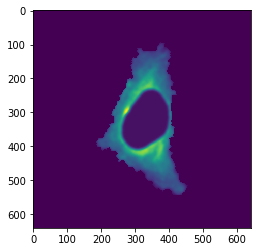

In [4]:
# Smoothening protein image.
proteinsSmooth = smooth_protein_image(proteins, pBodies, cellMask, nucleus, 0.05)
plt.imshow(proteinsSmooth)

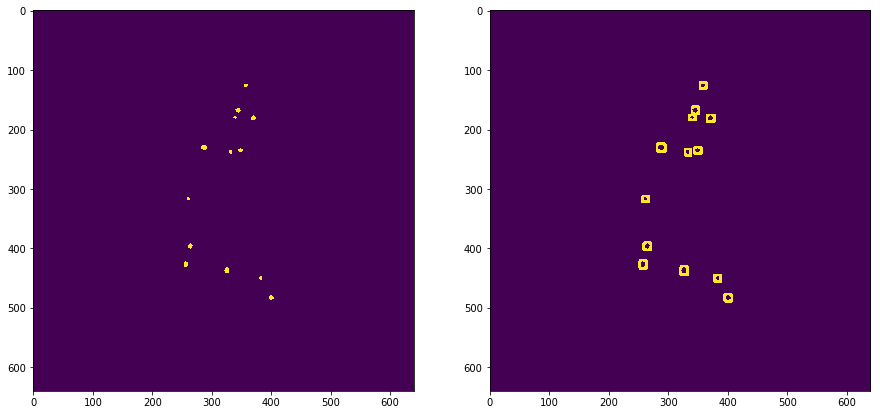

In [5]:
figs, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 40))

small_p_body_kernel = np.ones((3, 3), np.uint8)
no_small_p_bodies = cv2.morphologyEx(pBodies, cv2.MORPH_OPEN, small_p_body_kernel)

dilation_kernel = np.ones((10, 10), np.uint8)
dilated_pbodies = cv2.dilate(no_small_p_bodies, dilation_kernel)
axes[0].imshow(pBodies)
axes[1].imshow(dilated_pbodies - pBodies)
# axes[1].imshow(cv2.dilate(pBodies, kernel))

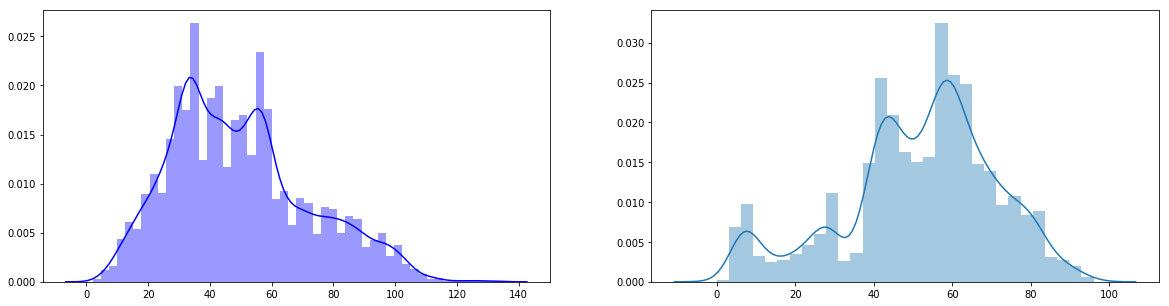

In [6]:
p_body_surroundings = dilated_pbodies - pBodies > 0

figs, axes = plt.subplots(1, 2, figsize = (20, 5))

sns.distplot(proteinsSmooth[(cellMask != 0) & (nucleus == 0)], color = "b", ax = axes[0])
sns.distplot(proteinsSmooth[p_body_surroundings], ax = axes[1])

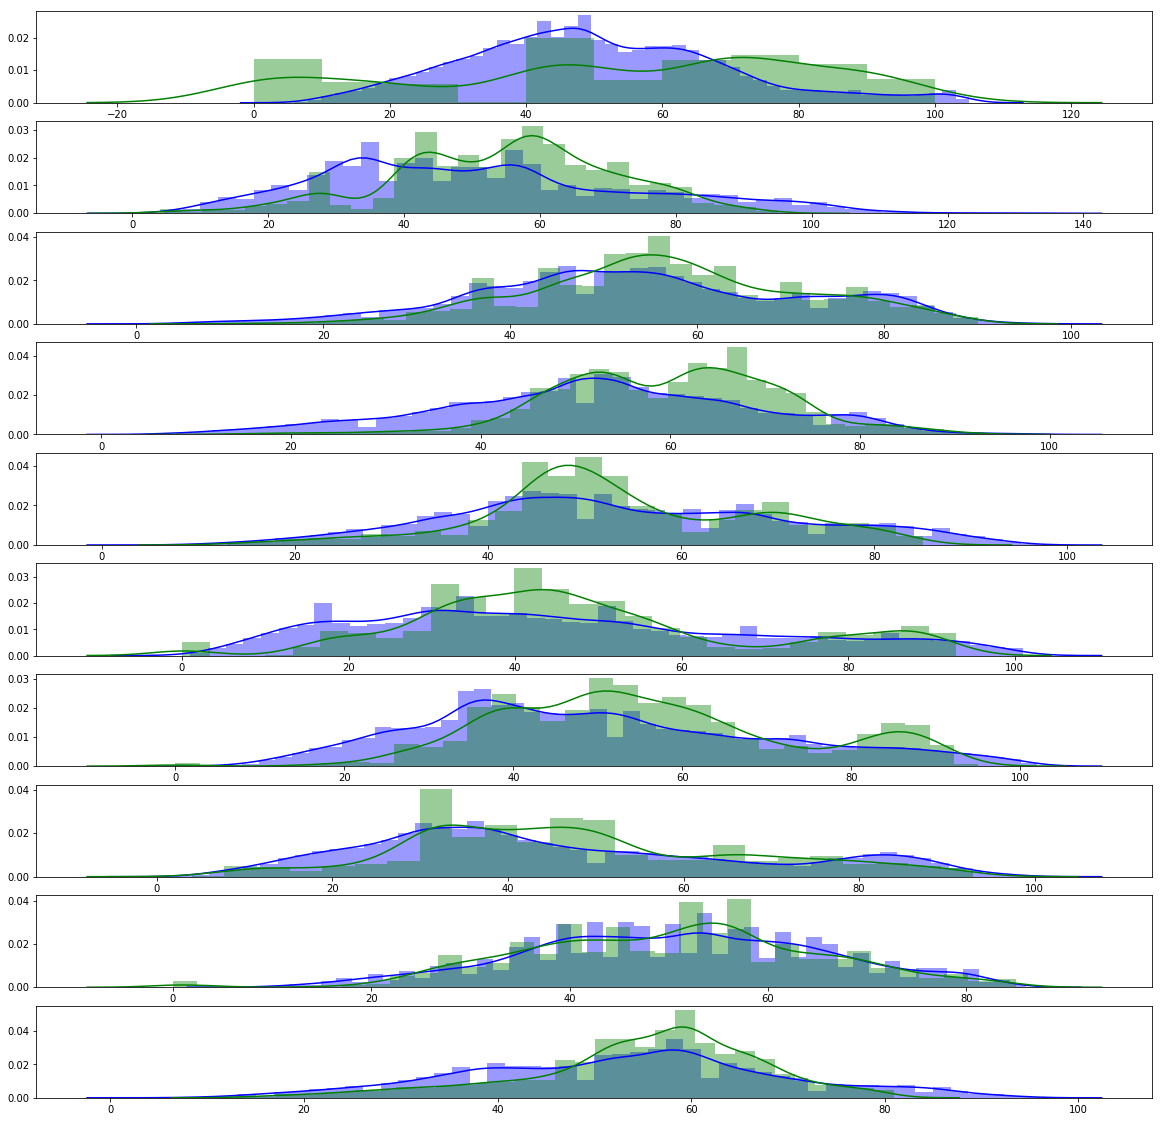

In [7]:
all_signal = []
pBody_signal = []
for n in range(len(images)):
    cellMask = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = 'segmentation', label =images[n]['label']), 0)
    pBodies  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Pbody_Segm', label = images[n]['label']), 0)
    nucleus  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '2_DAPI', label = images[n]['label']), 0)
    proteins = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Succs', label = images[n]['label']), 0)

    # Creating mask for the nucleus
    nucleus_smoothed = cv2.GaussianBlur(nucleus,(5,5),0)
    nucleus_mask = nucleus_smoothed > 10
    
    proteinsSmooth = smooth_protein_image(proteins, pBodies, cellMask, nucleus, 0, 10)

    # Distribution of protein signal in the cytoplasm.
    small_p_body_kernel = np.ones((3, 3), np.uint8)
    no_small_p_bodies = cv2.morphologyEx(pBodies, cv2.MORPH_OPEN, small_p_body_kernel)

    dilation_kernel = np.ones((10, 10), np.uint8)
    dilated_pbodies = cv2.dilate(no_small_p_bodies, dilation_kernel)
    
    dilated_pbodies[(cellMask == 0) | (nucleus_mask != 0)] = 0
    p_body_surroundings = dilated_pbodies - pBodies > 0

    all_signal.append(proteinsSmooth[(cellMask != 0) & (nucleus_mask == 0)])
    pBody_signal.append(proteinsSmooth[(p_body_surroundings)])
    
figs, axes = plt.subplots(10, 1, figsize = (20, 20))

for i in range(10):
    #plt.imshow(images[i])
    sns.distplot(all_signal[i], color = "b", ax = axes[i,])
    sns.distplot(pBody_signal[i], color = "g", ax = axes[i])

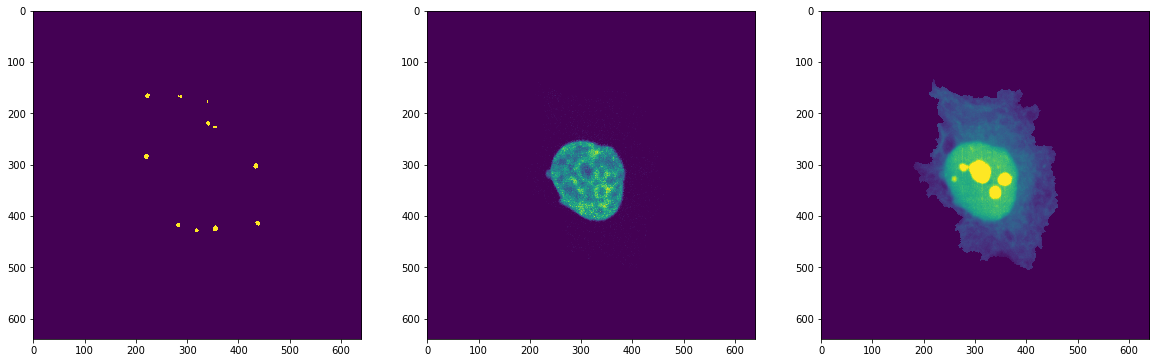

In [8]:
n = 4

figs, axes = plt.subplots(1, 3, figsize = (20, 40))

axes[0].imshow(cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Pbody_Segm', label = images[n]['label']), 0))
axes[1].imshow(cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '2_DAPI', label = images[n]['label']), 0))
axes[2].imshow(cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Succs', label = images[n]['label']), 0))


In [9]:
for i in range(10):
    print(np.mean(all_signal[i]) - np.mean(pBody_signal[i]))

-2.1024594257711513
-3.7815617253771805
-2.8906582614864718
-7.343151048122181
0.2227003712671518
-2.6523215652372016
-5.761706428787669
-1.8395683812790367
0.3459910140300977
-2.284114874410335


In [10]:
import cv2
import numpy as np

from p_body_randomness.smooth_image import smooth_protein_image

def calculate_mean_intensities(protein_signal, pbody_mask, cell_mask, nucleus_image):
    '''
    Function: Calculates average signal intensity in the cytoplasm and in areas surrounding p-bodies.
    Input:    Image files containing protein signal, p-body locations, cell segmentation, DAPI signal.
    Output:   Tuple, first float is average intensity in the cytoplasm, second float is average intensity around p-bodies.
    '''
    # Creating mask for the nucleus
    nucleus_smoothed = cv2.GaussianBlur(nucleus_image, (5,5), 0)
    nucleus_mask = nucleus_smoothed > 10
    
    # Removing small p-bodies from the image.
    small_p_body_kernel = np.ones((3, 3), np.uint8)
    no_small_p_bodies = cv2.morphologyEx(pBodies, cv2.MORPH_OPEN, small_p_body_kernel)

    # Dilating remaining p-bodies.
    dilation_kernel = np.ones((10, 10), np.uint8)
    dilated_pbodies = cv2.dilate(no_small_p_bodies, dilation_kernel)
    
    # Removing resulting areas that are not in the cytoplasm.
    dilated_pbodies[(cell_mask == 0) | (nucleus_mask != 0)] = 0
    
    # Determining which pixels are in p-body surroundings.
    p_body_surroundings = dilated_pbodies - pbody_mask > 0
    
    # Processing the image to make the protein signal smoother.
    proteins_smooth = smooth_protein_image(protein_signal, pbody_mask, cell_mask, nucleus_image)
    
    # Calculating average signal in the p-body surroundings.
    surroundings_signal = proteins_smooth[p_body_surroundings]
    surr_mean = np.mean(surroundings_signal)
    
    # Calculating average signal in the cytoplasm.
    cytoplasm_signal = proteins_smooth[(cell_mask != 0) & (nucleus_mask == 0)]
    cyto_mean = np.mean(cytoplasm_signal)
    
    return (cyto_mean, surr_mean)

In [11]:
from pathlib import Path
from p_body_randomness.centroids import extract_centroids
from p_body_randomness.smooth_image import smooth_protein_image

# Importing image files.
TEMPLATE_PATH = '../data/input_data/20180606-SLP_Multiplexing_p1_C03_x00{x}_y000_z000_t000_{image_type}_Label{label}.png'
NUM_IMAGES = 10
MIN_CENTROIDS = 5

image_types = {'pbodies': '13_Pbody_Segm', 'protein': '13_Succs', 'cellmask': 'segmentation', 'dapi': '2_DAPI'}

images = []
while len(images) < NUM_IMAGES:
    candidate = {'x': np.random.randint(0, 5), 'label': np.random.randint(0, 40)}
    if Path(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies'])).is_file():
        if len(extract_centroids(cv2.imread(TEMPLATE_PATH.format(**candidate, image_type=image_types['pbodies']), 0))) >= MIN_CENTROIDS:
            images.append(candidate)
            
n = 9

cellMask = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = 'segmentation', label =images[n]['label']), 0)
pBodies  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Pbody_Segm', label = images[n]['label']), 0)
nucleus  = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '2_DAPI', label = images[n]['label']), 0)
proteins = cv2.imread(TEMPLATE_PATH.format(x = images[n]['x'], image_type = '13_Succs', label = images[n]['label']), 0)

print(calculate_mean_intensities(proteins, pBodies, cellMask, nucleus))

(40.19444043060472, 49.50139405204461)


Results After Running the Simulations and Doing Calculations for 30 000 Cells.

In [12]:
# Load in all csv result files & combine them to one pandas table
wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
         'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16',
         'E04', 'E05', 'E06', 'E07', 'E08', 'F04', 'F05', 'F06', 'F07', 'F08']

base_path = '../results/run3_volume_sampling/NearestNeighborResults_VolumeSampling_'

results = pd.DataFrame()

for well in wells:
    curr_well = pd.read_csv(base_path + well + '.csv')
    results = pd.concat([results, curr_well])

In [13]:
print(results.columns)

Index(['Area_of_Cytoplasm', 'Label', 'Mean_Of_mean_nn_distances_simulated_10',
       'Mean_Of_mean_nn_distances_simulated_100',
       'Mean_Of_mean_nn_distances_simulated_1000',
       'Mean_nn_distances_measured', 'Mean_nn_distances_simulated',
       'Mean_protein_intensity_around_pbodies',
       'Mean_protein_intensity_cytoplasm', 'Number_of_pbodies', 'SiteX',
       'SiteY', 'Well', 'p-value_measured_lower_1000_sim'],
      dtype='object')


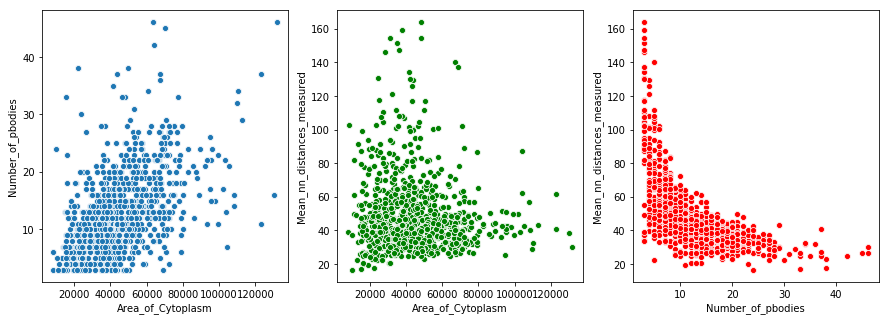

In [20]:
figs, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

sns.scatterplot(data = results, x = "Area_of_Cytoplasm", y = "Number_of_pbodies", ax = axes[0])
sns.scatterplot(data = results, x = "Area_of_Cytoplasm", y = "Mean_nn_distances_measured", color = "g", ax = axes[1])
sns.scatterplot(data = results, x = "Number_of_pbodies", y = "Mean_nn_distances_measured", color = "r", ax = axes[2])

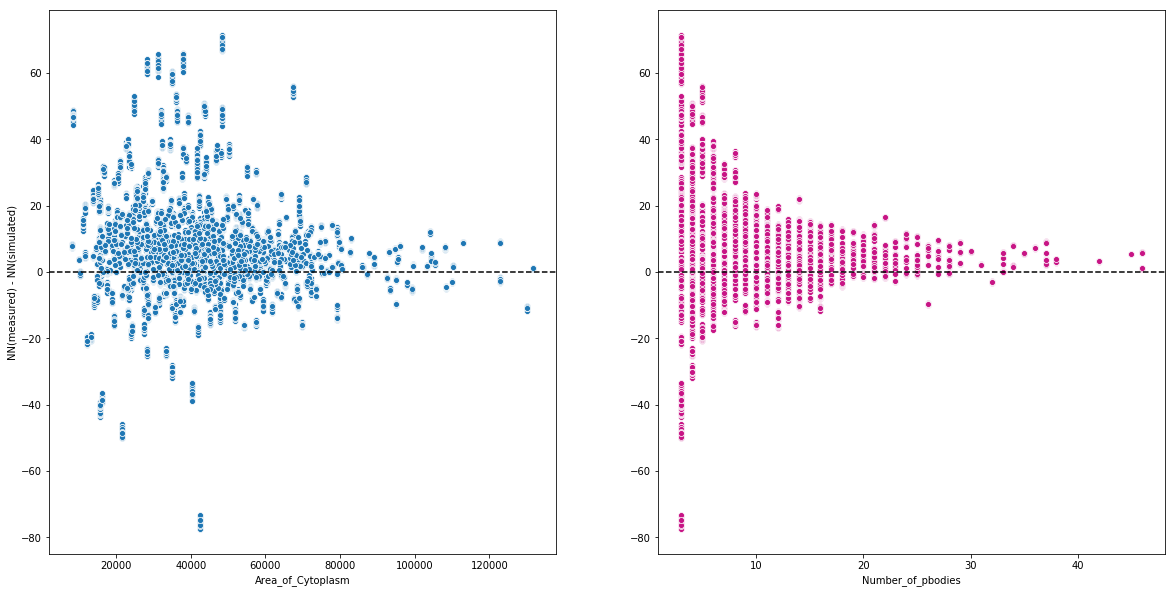

In [25]:
figs, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
dist_Diff = results["Mean_nn_distances_measured"].values - results["Mean_Of_mean_nn_distances_simulated_1000"].values

sns.scatterplot(data = results, x = "Area_of_Cytoplasm", y = dist_Diff, ax = axes[0])
sns.scatterplot(data = results, x = "Number_of_pbodies", y = dist_Diff, color = 'mediumvioletred', ax = axes[1])
axes[0].axhline(0, ls='--', color = 'black')
axes[0].set(ylabel='NN(measured) - NN(simulated)')
axes[1].axhline(0, ls='--', color = 'black')

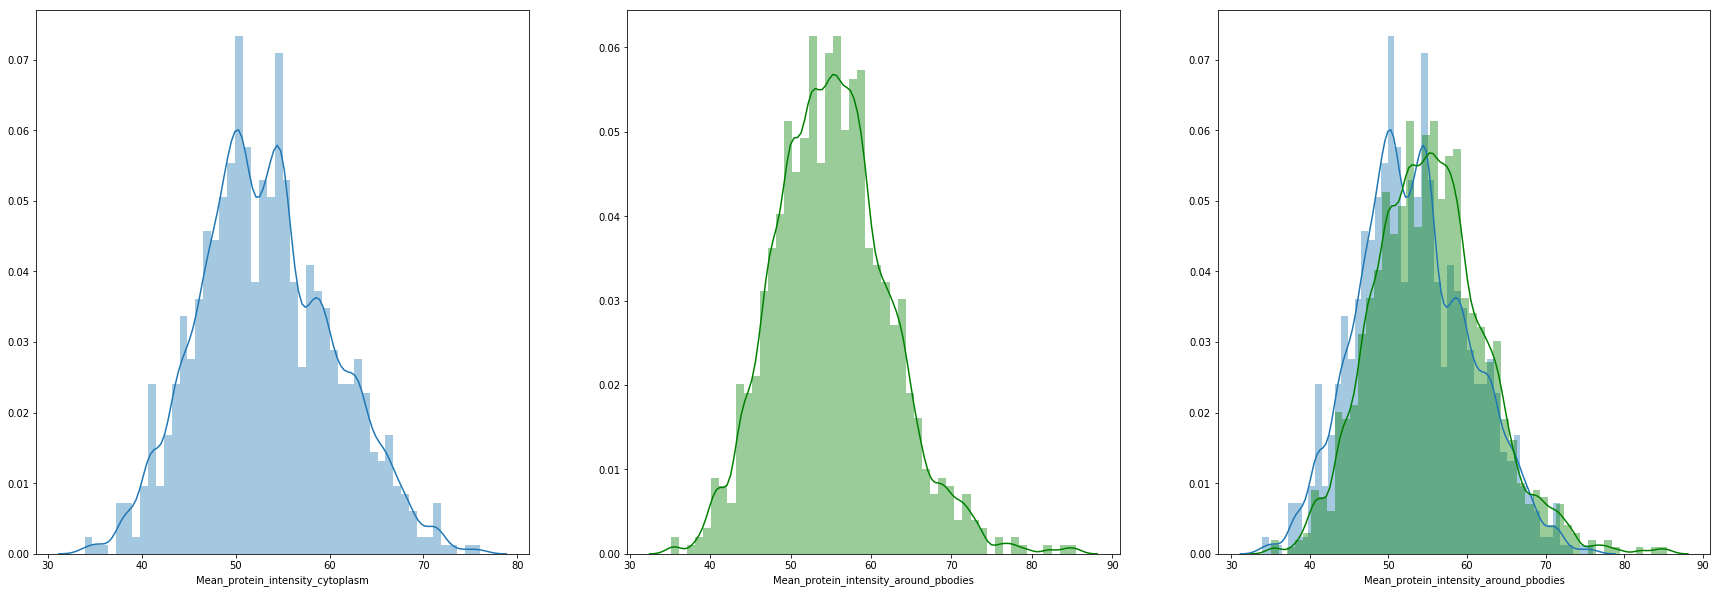

In [27]:
# Plotting the distribution of the mean instensites in the cytoplasms and in the p-bodies.
figs, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

sns.distplot(a = results["Mean_protein_intensity_cytoplasm"], ax = axes[0])
sns.distplot(a = results["Mean_protein_intensity_around_pbodies"], color = 'g', ax = axes[1])
sns.distplot(a = results["Mean_protein_intensity_cytoplasm"], ax = axes[2])
sns.distplot(a = results["Mean_protein_intensity_around_pbodies"], color = 'g', ax = axes[2])

Ttest_relResult(statistic=62.77386031322394, pvalue=0.0)


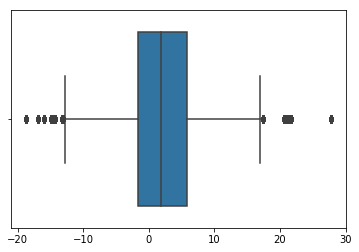

In [29]:
intensityDiff = results["Mean_protein_intensity_around_pbodies"].values - results["Mean_protein_intensity_cytoplasm"].values

sns.boxplot(intensityDiff)
print(stats.ttest_rel(results["Mean_protein_intensity_around_pbodies"].values, results["Mean_protein_intensity_cytoplasm"].values))